# GAN 3.0
Through my research, I was able to decided to use a GAN to create music. I would first convert .wav files to pngs and use that throughout my GAN. 

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

The import statement above is used for some prints and special uses from tensorflow beta 2.0. Below of the required import statements to run and use the GAN

In [7]:
import tensorflow as tf
import glob#finds pathnames
import imageio#handles image input and output
import matplotlib.pyplot as plt#data visulization
import numpy as np#obivous array and math uses
import os#helps uses files across different os
import PIL#pictures
import numpy
import math
from PIL import Image
from scipy.io.wavfile import read, write
from tensorflow.keras import layers#layers in the neural nets
import time#to figure out timings
from progress.bar import Bar

from IPython import display#will show the resulting converted pngs
BATCH_SIZE = 1

# Inputting .wav files and Converting them

In [23]:

#os.chdir("/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001")
#os.chdir(",'+r')
s="C:\\Users\\vigne\\Documents\\GitHub\\AI-Music-Generator\\ViolinMIDI\\bwv1001\\"
# read the WAV data
if os.path.isdir(s):
    os.chdir(s)
else:
    print("Directory not exists.")
wavs_in = []
png_data = []
song=0
print("out")

for filename in glob.glob("*.wav"):
    print(filename)
    print("work")
    wavs_in.append(read(filename))
    wav_data = list(wavs_in[song][1])
    #print(list(wavs_in[song]))
    png_data = []
    print("after png")
    for d in wav_data:
        # split all 16-bit integers in WAV file to 2x 8 bit integers;
        # 1 16 bit int per pixel
        d_1 = (((d[0] >> 8) & 0xff), d[0] & 0xff, 0)
        d_2 = (((d[1] >> 8) & 0xff), d[1] & 0xff, 0)
        png_data.append(d_1)
        png_data.append(d_2)
    print("append")
    # ending indicator pixel uses the green channel
    # (green channel set to 0 for all data pixels)
    png_data += [(255, 255, 255)]
    # find a roughly square size of output image
    n = len(png_data)
    x = math.floor(math.sqrt(n))
    y = x + math.ceil((n - x ** 2) / x)

    # output the PNG image
    img = PIL.Image.new('RGB', (int(x), int(y)), color = 'white')
    img.putdata(png_data)
    img.save(filename.replace(".wav",".png"))
    song+=1
print("fin")

out
vp1-1al.wav
work
after png
append
vs1-1ada.wav
work
after png
append
vs1-2fug.wav
work
after png
append
vs1-3sic.wav
work
after png
append
vs1-4prs.wav
work
after png
append
fin


# Generator

In [24]:
def generator_model():

    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=True,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=True))
    assert model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=True))
    assert model.output_shape==(None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=True,activation='sigmoid'))
    assert model.output_shape==(None,28,28,1)
    
    return model

TypeError: Image data of dtype object cannot be converted to float

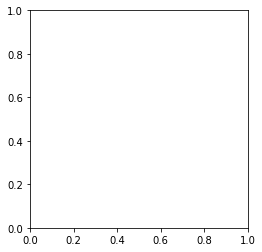

In [26]:
generator=generator_model()

noise=tf.random.normal([1, 100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0],cmap='gray')

# Discriminator

In [94]:
def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [95]:
discriminator=discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.02759453]], shape=(1, 1), dtype=float32)


# Adding Losses and Optimizers

In [96]:
#keras helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [97]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [98]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [99]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [100]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

# Training Epochs

In [101]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [102]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [103]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [104]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Training the model

In [31]:
%%time
from scipy import ndimage, misc
filepath="/Users/viggy/Documents/GitHub/AI-Music-Generator/ViolinMIDI/bwv1001/vs1-1ada.png"
data=Image.open(s+"vp1-1al.png")
#data.shape
#mage_resized = misc.imresize(image, (64, 64))
#data = data.reshape(28, 28, 1).astype('float32')
#data = (data - 127.5) / 127.5 # Normalize the images to [-1, 1]
uploaded=tf.image.decode_png(s+"vp1-1al.png")
uploaded = uploaded.reshape(uploaded.shape[0], 28, 28, 1).astype('float32')
uploaded = (uploaded - 127.5) / 127.5 # Normalize the images to [-1, 1]

images.append(image_resized)
train(images, EPOCHS)

AttributeError: 'Tensor' object has no attribute 'reshape'

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))